## Install and Import Dependencies

In [1]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 22.4 MB/s 
     |████████████████████████████████| 168 kB 37.4 MB/s 
     |████████████████████████████████| 182 kB 49.3 MB/s 
     |████████████████████████████████| 63 kB 805 kB/s 
     |████████████████████████████████| 168 kB 52.2 MB/s 
     |████████████████████████████████| 166 kB 21.3 MB/s 
     |████████████████████████████████| 166 kB 42.4 MB/s 
     |████████████████████████████████| 162 kB 53.2 MB/s 
     |████████████████████████████████| 162 kB 65.7 MB/s 
     |████████████████████████████████| 158 kB 29.1 MB/s 
     |████████████████████████████████| 157 kB 49.6 MB/s 
     |████████████████████████████████| 157 kB 44.6 MB/s 
     |████████████████████████████████| 157 kB 53.5 MB/s 
     |████████████████████████████████| 157 kB 27.9 MB/s 
     |████████████████████████████████| 157 kB 59.8 MB/s 
     |████████████████████████████████| 157 kB 54.6 MB/s 
     |████████████████████████████████| 157 kB 22.8 MB/s 
     |██████████

In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 30.2 MB/s 
     |████████████████████████████████| 66 kB 4.0 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 


In [3]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb

from codecarbon import EmissionsTracker
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Fetch and Data Segregation

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "face_mask_detection",
  "artifact_name": "face_mask_raw_data:latest",
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: thaisaraujom. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact face_mask_raw_data:latest, 328.92MB. 11792 files... 
wandb:   11792 of 11792 files downloaded.  
Done. 0:3:53.2
23-11-2022 23:06:20 Path: ./artifacts/face_mask_raw_data:v0


In [8]:
run.finish()

In [9]:
data_dir

'./artifacts/face_mask_raw_data:v0'

In [ ]:
# # open the W&B project created in the Fetch step
# run = wandb.init(entity="thaisaraujom",project=args["project_name"], job_type="transfer_learning")

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 11792 files belonging to 2 classes.


In [12]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [14]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 369
Number of train batches: 296
Number of validation batches: 59
Number of test batches: 14


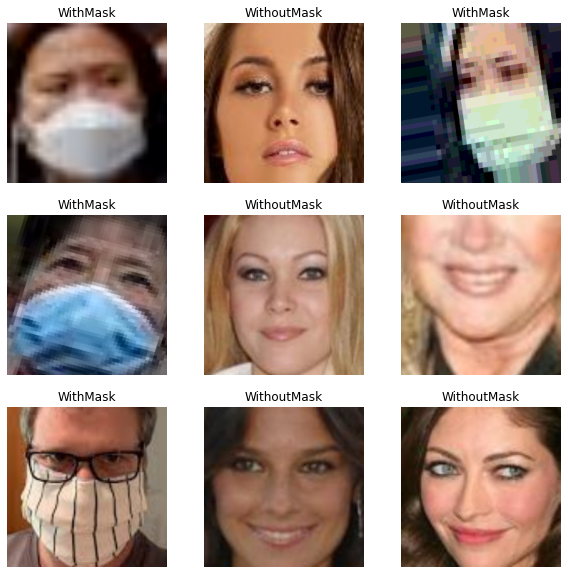

In [15]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

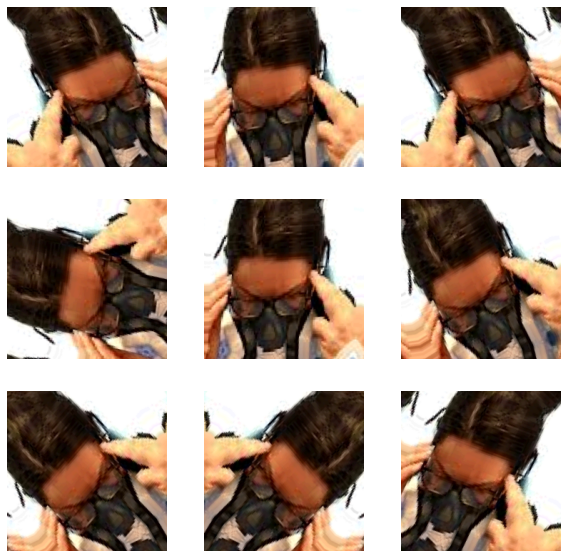

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Create the base model from the pre-trained convnets


<p align="center" style="text-align:center">
    <img width='100%' src="https://drive.google.com/uc?export=view&id=1FyLl5iR8fy_Z65HsXMaWBMpZT6q1xRJn">
</p>

You will create the base model from the [MobileNet model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet). This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify if a person is with or without mask from our specific dataset.

First, you need to pick which layer of MobileNet you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.




In [19]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE,
                                                       include_top=False,
                                                       weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [20]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

This feature extractor converts each 224x224x3 image into a 7x7x1024 block of features. Let's see what it does to an example batch of images:




In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


## Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet has many layers, so setting the entire model's trainable flag to False will freeze all of them. This is crucial only in case we are using [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers in the model.

> Many models contain [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When you set ``layer.trainable = False``, the **BatchNormalization** layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains **BatchNormalization** layers in order to do fine-tuning, you should keep the **BatchNormalization** layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [22]:
model.trainable = False

In [23]:
args = {
  "project_name": "face_mask_detection"
}

# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",
                 project=args["project_name"], 
                 job_type="feature_extraction")

## Add a classification head

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 1024-element vector per image.




In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into a single prediction per image.

In [25]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Build a model by chaining together the data augmentation, [tf.keras.applications.mobilenet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input), model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use ``training=False`` is only redundant because our models not contains a BatchNormalization layer. However, use it here is important for the sake of understanding. 

In [26]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

Compile the model before training it.

In [27]:
# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                             

The 3,228,864 million parameters in MobileNet are frozen, but there are 2,050 thousand trainable parameters in the Dense layer. These are divided between two [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects, the weights and biases.




In [29]:
len(model.trainable_variables)

2

## Train and Evalute the model

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [30]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)
# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

23-11-2022 23:17:56 [INFO] training network...


Epoch 1/20
296/296 [==============================] - 30s 84ms/step - loss: 0.2649 - accuracy: 0.8849 - val_loss: 0.0900 - val_accuracy: 0.9815
Epoch 2/20
296/296 [==============================] - 27s 81ms/step - loss: 0.0858 - accuracy: 0.9706 - val_loss: 0.0490 - val_accuracy: 0.9878
Epoch 3/20
296/296 [==============================] - 27s 80ms/step - loss: 0.0563 - accuracy: 0.9802 - val_loss: 0.0360 - val_accuracy: 0.9905
Epoch 4/20
296/296 [==============================] - 27s 81ms/step - loss: 0.0470 - accuracy: 0.9845 - val_loss: 0.0310 - val_accuracy: 0.9958
Epoch 5/20
296/296 [==============================] - 27s 81ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0275 - val_accuracy: 0.9942
Epoch 6/20
296/296 [==============================] - 28s 85ms/step - loss: 0.0367 - accuracy: 0.9883 - val_loss: 0.0247 - val_accuracy: 0.9958
Epoch 7/20
296/296 [==============================] - 27s 81ms/step - loss: 0.0343 - accuracy: 0.9882 - val_loss: 0.0205 - val_accuracy:

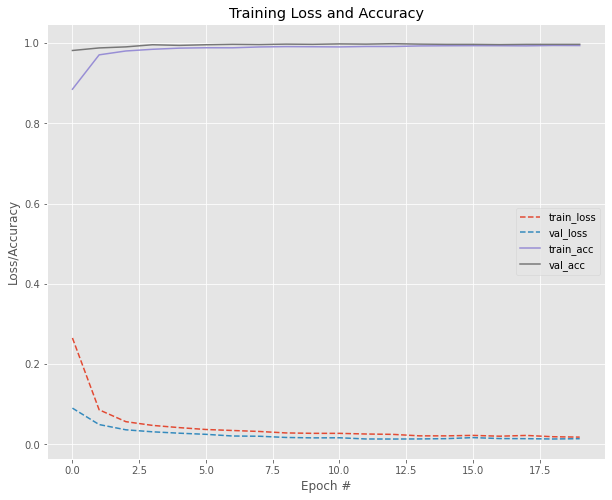

In [31]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [32]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.017438420136366845 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0008232377415614921 kWh
[INFO] Energy consumed for all GPU: 0.009248161342266005 kWh
[INFO] Energy consumed for all CPU: 0.007367021052539349 kWh
[INFO] CO2 emission 0.01100334950285085(in Kg)


Note the dataset is a generator (``tensorflow.python.data.ops.dataset_ops.PrefetchDataset``). Thus, each time you call the dataset object a new (and different) sequence of images will be returned. This is very important to guarantee the same sequence is used in ``model.predict(test_dataset)`` and ``true_labels``. 

In [33]:
type(test_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [34]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [35]:
# as previous mentioned, y is different of y2
# because test_dataset is a generator
assert y == y2

ValueError: ignored

A possible solution is to extract a snapshot of ``test_dataset``.

In [36]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [37]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names, digits=4))

[INFO] evaluating network...
14/14 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

    WithMask     0.9952    0.9905    0.9928       210
 WithoutMask     0.9916    0.9958    0.9937       238

    accuracy                         0.9933       448
   macro avg     0.9934    0.9931    0.9933       448
weighted avg     0.9933    0.9933    0.9933       448



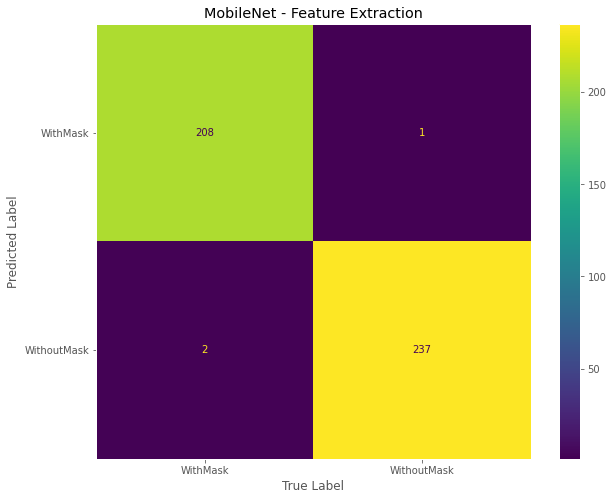

In [38]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_title("MobileNet - Feature Extraction")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [39]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

23-11-2022 23:32:16 Uploading figures


In [40]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

23-11-2022 23:32:50 Validation Evaluation metrics
23-11-2022 23:32:50 Validation Accuracy: 0.9933035714285714
23-11-2022 23:32:50 Validation Precision: 0.9933115703389321
23-11-2022 23:32:50 Validation Recall: 0.9933035714285714
23-11-2022 23:32:50 Validation F1: 0.9933025997808499


In [41]:
run.finish()

Acc,0.9933
CO2_Emissions,0.011
Count_Params,3230914
Energy_CPU,0.00737
Energy_Consumed,0.01744
Energy_GPU,0.00925
Energy_RAM,0.00082
F1,0.9933
Precision,0.99331
Recall,0.9933


# Fine-tuning networks

In the previous section we learned how to treat a pre-trained **Convolutional Neural Network** as **feature extractor**. 

> Using this feature extractor, we forward propagated our dataset of images through the network, extracted the activations at a given layer, and saved the values to disk. A shallow machine
learning classifier was then trained on top of the CNN features.

This CNN feature extractor approach, called **transfer learning**, obtained remarkable accuracy, far higher than any of our previous experiments on the Animals dataset.

But there is another type of transfer learning, one that can actually outperform the feature extraction method if you have sufficient data. This method is called **fine-tuning** and **requires us to perform “network surgery”**. 

1. First, we take a **scalpel and cut off the final set of fully-connected layers** (i.e., the “head” of the network) from a pre-trained /Convolutional Neural Network, such as
VGG, ResNet, Inception, so on. 
2. We then **replace the head** with a new set of fully-connected layers with random initializations. From there all layers below the head are frozen so their weights cannot be
updated (i.e., the backward pass in backpropagation does not reach them)
3.  We then train the network **using a very small learning rate** so the new set of FC layers can start to learn patterns from the previously learned CONV layers earlier in the network. 
4. Optionally, we may unfreeze the rest of the network and continue training. Applying fine-tuning allows us to apply pre-trained networks to recognize classes that they were not originally trained on; furthermore, **this method can lead to higher accuracy than feature extraction**.

## Transfer Learning and Fine-tuning

The fine-tuning technique is very similar to the feature extractor, however, instead of just removing the fully connected layer and outputting a feature vector, a new fully connected layer is added, generally simpler than the original one, acting directly as a classifier. The network training using this technique is divided into two stages: initially, all layers of the pre-trained model are frozen (that is, their weights and biases are not trainable), only the new fully connected layer is unfrozen, and there is the first stage of training. Then all or some layers of the pre-trained model are thawed and there is a second training step with this new configuration.

In [42]:
args = {
  "project_name": "face_mask_detection"
}

# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",
                 project=args["project_name"], 
                 job_type="fine_tuning")

## Indexes and Layers

Prior to performing **network surgery**, we need to know the **layer name and index** of every layer in a given deep learning model. We need this information as we’ll be required to **“freeze”** and **“unfreeze”** certain layers in a pre-trained CNN.

Without knowing the layer names and indexes ahead of time, we would be “cutting blindly”, an out-of-control surgeon with no game plan. **If we instead take a few minutes to examine the network architecture and implementation, we can better prepare for our surgery.**

In [43]:
# import the necessary packages
from tensorflow.keras.applications import MobileNet

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = MobileNet(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

23-11-2022 23:35:23 `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	BatchNormalization
[INFO] 3	ReLU
[INFO] 4	DepthwiseConv2D
[INFO] 5	BatchNormalization
[INFO] 6	ReLU
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	ReLU
[INFO] 10	ZeroPadding2D
[INFO] 11	DepthwiseConv2D
[INFO] 12	BatchNormalization
[INFO] 13	ReLU
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	ReLU
[INFO] 17	DepthwiseConv2D
[INFO] 18	BatchNormalization
[INFO] 19	ReLU
[INFO] 20	Conv2D
[INFO] 21	BatchNormalization
[INFO] 22	ReLU
[INFO] 23	ZeroPadding2D
[INFO] 24	DepthwiseConv2D
[INFO] 25	BatchNormalization
[INFO] 26	ReLU
[INFO] 27	Conv2D
[INFO] 28	BatchNormalization
[INFO] 29	ReLU
[INFO] 30	DepthwiseConv2D
[INFO] 31	BatchNormalization
[INFO] 32	ReLU
[INFO] 33	Conv2D
[INFO] 34	BatchNormalization
[INFO] 35	ReLU
[INFO] 36	ZeroPadding2D
[INFO] 37	DepthwiseConv2D
[INFO] 38	BatchNormalization
[INFO] 39	ReLU
[INFO] 40	Conv2D
[INFO] 41	BatchNormalization
[INFO] 42	ReLU
[INFO] 43	Depthwise

Before we can replace the head of a pre-trained CNN, we need something to replace it with – therefore, we need to define our own fully-connected head of the network.

In [44]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

## All in one

### First Stage

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [46]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [47]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [48]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [49]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [50]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [51]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [52]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	TFOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [53]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [54]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [55]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [56]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)
# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/3
296/296 [==============================] - 32s 93ms/step - loss: 0.1344 - accuracy: 0.9805 - val_loss: 0.1327 - val_accuracy: 0.9831
Epoch 2/3
296/296 [==============================] - 29s 87ms/step - loss: 0.0553 - accuracy: 0.9927 - val_loss: 0.0136 - val_accuracy: 0.9974
Epoch 3/3
296/296 [==============================] - 28s 86ms/step - loss: 0.0497 - accuracy: 0.9940 - val_loss: 0.0191 - val_accuracy: 0.9984


### Second Stage

In [58]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	TFOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [59]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	BatchNormalization
[INFO] 3	ReLU
[INFO] 4	DepthwiseConv2D
[INFO] 5	BatchNormalization
[INFO] 6	ReLU
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	ReLU
[INFO] 10	ZeroPadding2D
[INFO] 11	DepthwiseConv2D
[INFO] 12	BatchNormalization
[INFO] 13	ReLU
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	ReLU
[INFO] 17	DepthwiseConv2D
[INFO] 18	BatchNormalization
[INFO] 19	ReLU
[INFO] 20	Conv2D
[INFO] 21	BatchNormalization
[INFO] 22	ReLU
[INFO] 23	ZeroPadding2D
[INFO] 24	DepthwiseConv2D
[INFO] 25	BatchNormalization
[INFO] 26	ReLU
[INFO] 27	Conv2D
[INFO] 28	BatchNormalization
[INFO] 29	ReLU
[INFO] 30	DepthwiseConv2D
[INFO] 31	BatchNormalization
[INFO] 32	ReLU
[INFO] 33	Conv2D
[INFO] 34	BatchNormalization
[INFO] 35	ReLU
[INFO] 36	ZeroPadding2D
[INFO] 37	DepthwiseConv2D
[INFO] 38	BatchNormalization
[INFO] 39	ReLU
[INFO] 40	Conv2D
[INFO] 41	BatchNormalization
[INFO] 42	ReLU
[INFO] 43	DepthwiseConv2D
[INFO] 44	BatchNormalization
[INFO] 45	ReLU


In [60]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [61]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [62]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [63]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [64]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)
# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/10
296/296 [==============================] - 58s 174ms/step - loss: 0.0518 - accuracy: 0.9926 - val_loss: 0.0334 - val_accuracy: 0.9905
Epoch 2/10
296/296 [==============================] - 52s 167ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 0.0088 - val_accuracy: 0.9974
Epoch 3/10
296/296 [==============================] - 53s 170ms/step - loss: 0.0189 - accuracy: 0.9960 - val_loss: 0.0138 - val_accuracy: 0.9974
Epoch 4/10
296/296 [==============================] - 52s 167ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0153 - val_accuracy: 0.9974
Epoch 5/10
296/296 [==============================] - 52s 167ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 0.0087 - val_accuracy: 0.9979
Epoch 6/10
296/296 [==============================] - 53s 169ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0109 - val_accuracy: 0.9974
Epoch 7/10
296/296 [==============================] - 53s 169ms/step - loss: 0.0065 - accuracy: 0.9980 - v

Additional accuracy can be obtained by performing more aggressive data augmentation and continually unfreezing more and more CONV blocks in MobileNet. While fine-tuning is certainly more work than feature extraction, it also enables us to tune and modify the weights in our CNN to a particular dataset – something that feature extraction does not allow. Thus, when given enough training data, consider applying fine-tuning as you’ll likely obtain higher classification accuracy
than simple feature extraction alone.

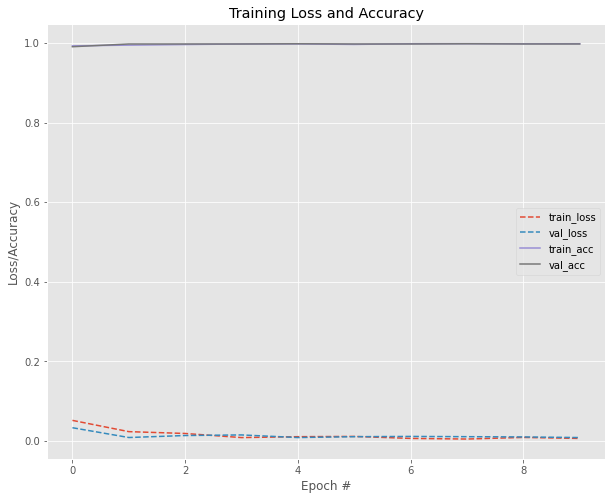

In [65]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [66]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [67]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names, digits=4))

[INFO] evaluating network...
14/14 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

    WithMask     0.9955    1.0000    0.9978       222
 WithoutMask     1.0000    0.9956    0.9978       226

    accuracy                         0.9978       448
   macro avg     0.9978    0.9978    0.9978       448
weighted avg     0.9978    0.9978    0.9978       448



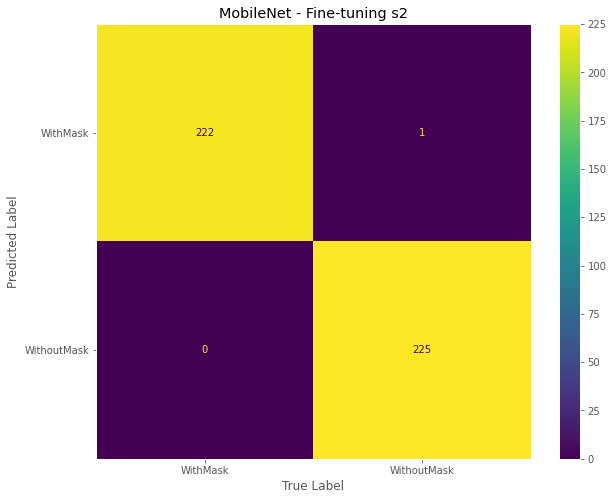

In [68]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_title("MobileNet - Fine-tuning s2")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [69]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

23-11-2022 23:52:25 Uploading figures


In [70]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

23-11-2022 23:52:30 Validation Evaluation metrics
23-11-2022 23:52:30 Validation Accuracy: 0.9977678571428571
23-11-2022 23:52:30 Validation Precision: 0.9977778667520819
23-11-2022 23:52:30 Validation Recall: 0.9977678571428571
23-11-2022 23:52:30 Validation F1: 0.9977678905090526


In [71]:
run.finish()

Acc,0.99777
CO2_Emissions,0.01145
Count_Params,16074690
Energy_CPU,0.00769
Energy_Consumed,0.01814
Energy_GPU,0.00959
Energy_RAM,0.00086
F1,0.99777
Precision,0.99778
Recall,0.99777
